# **Capstone Project**

## **Pneumonia Detection**

**Problem Statement:** Chest Radiograph is the most commonly used or performed diagnostic imaging Technology. Due to high volume of chest radiography, it could be very time consuming and intensive for the radiologists to review each image manually. As such, an automated solution is ideal to locate the position of inflammation in an image. By having such an automated pneumonia screening system, this can assist physicians to make better clinical decisions.



**Business Domain Value:** Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

Details about the data and dataset files are given in below link, https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

**Purpose of this project:** Find out a patient with pnuemonia disease. There are some patients, which have some symptoms but not sure they might get affected by this diesea or not. This project also help to find out those patients, who have some symptoms and might get affected by this disease.

In [ ]:
# Mounting Google CoLab
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 28 07:46:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Memory capacity etails

from psutil import virtual_memory
ram = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram))

if ram < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
!pip install pydicom
!pip install mrcnn
import pydicom as pyd
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import os
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from collections import defaultdict
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

In [ ]:
#Unzip the .zip file

#from zipfile import ZipFile

#with ZipFile('/content/drive/MyDrive/AI_ML_Projects/Capstone Project/rsna-pneumonia-detection-challenge.zip', 'r') as z:
  #z.extractall()

### **Pre-Processing, Data Visualization, EDA**

In [ ]:
# Setting path
root_path =  '/content/drive/MyDrive/AI_ML_Projects/Capstone Project/'
os.chdir(root_path)

In [ ]:
# Checking file format (.dcm) in the train images folder

for file in os.listdir((os.path.join(root_path,'stage_2_train_images'))):
  if not file.endswith('.dcm'):
    print(file)
  #else:
    #print('All files inside Train Images folder are .dcm format')

In [ ]:
# Checking file format (.dcm) in the test images folder

for file in os.listdir((os.path.join(root_path,'stage_2_test_images'))):
  if not file.endswith('.dcm'):
    print(file)
  #else:
    #print('All files inside Test Images folder are .dcm format')

In [ ]:
label_meta_data = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv')

print('Size of Dataset 1: ',train_labels_df.shape)
print('Size of Dataset 2: ',label_meta_data.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels_df['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',label_meta_data['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (30227, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


In [ ]:
train_labels_df.drop_duplicates(inplace=True)
label_meta_data.drop_duplicates(inplace=True)
print('Size of Dataset 1: ',train_labels_df.shape)
print('Size of Dataset 2: ',label_meta_data.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels_df['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',label_meta_data['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (26684, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


In [ ]:
label_meta_data.head(10)

patientId                         class
0   0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1   00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2   00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3   003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4   00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6   00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7   006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8   00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
10  008c19e8-a820-403a-930a-bc74a4053664  No Lung Opacity / Not Normal
11  009482dc-3db5-48d4-8580-5c89c4f01334                        Normal

In [ ]:
train_labels_df.head(10)

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

**Compare the labels and class information for possible join**

In [ ]:
print("Shape of the train labels:", train_labels_df.shape)
print("Shape of the detailed class information:", label_meta_data.shape)

Shape of the train labels: (30227, 6)
Shape of the detailed class information: (26684, 2)


**Data Inference:** A join or merge should typically give us a dataset that has a shape of (30227) assuming we keep all rows and drop the redundant 'patientId' column.

**Check uniqueness of the data**

**Approach:**

There could be duplicate patientID entries, resulting to multiple bounding boxes with relative target classification/class information.
Compare if the sequence of records are synchronous between the "train labels" and "class information" datasets.
If synchronous then a simple join can be performed on the index

**Exploring Train Labels Dataset**

In [ ]:
grouped_data_label=pd.DataFrame()
grouped_data_label = train_labels_df['patientId'].value_counts().value_counts().reset_index()
grouped_data_label.columns = ['Counts', 'records in train labels']
grouped_data_label.style.hide_index()

In [ ]:
total_unique_data_labels = grouped_data_label['records in train labels'].sum()
print("Total unique records in train labels = ", total_unique_data_labels)

Total unique records in train labels =  26684


**Inference:**

1.   There are 23,286 unique entries and 3,398 entries that have duplicates.
To further elaborate, 3,398 patients have multiple indicators ranging from 2 
to 4.


2.   In total, the unique entries are 26,684 meaning there are 26,684 patients in the training sample. If the training sample is consistent, we should have the same number in the "class information" dataset and also the same number of images in the training images directory.



**Exploring Class Information Dataset**

In [ ]:
grouped_data_class=pd.DataFrame()
grouped_data_class = label_meta_data['patientId'].value_counts().value_counts().reset_index()
grouped_data_class.columns = ['counts', 'records in class info']
grouped_data_class.style.hide_index()

In [ ]:
total_unique_data_class= grouped_data_class['records in class info'].sum()
print("Total unique records in class info = ", total_unique_data_class)

Total unique records in class info =  26684


**Merging Data**

In [ ]:
merged_df = pd.merge(left = label_meta_data, right = train_labels_df, how = 'left', on = 'patientId')

#del label_meta_data, train_labels_df

merged_df.info(null_counts = True)
merged_df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


patientId  ... Target
0   0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...      0
1   00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...      0
2   00322d4d-1c29-4943-afc9-b6754be640eb  ...      0
3   003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...      0
4   00436515-870c-4b36-a041-de91049b9ab4  ...      1
5   00436515-870c-4b36-a041-de91049b9ab4  ...      1
6   00569f44-917d-4c86-a842-81832af98c30  ...      0
7   006cec2e-6ce2-4549-bffa-eadfcd1e9970  ...      0
8   00704310-78a8-4b38-8475-49f4573b2dbb  ...      1
9   00704310-78a8-4b38-8475-49f4573b2dbb  ...      1
10  008c19e8-a820-403a-930a-bc74a4053664  ...      0
11  009482dc-3db5-48d4-8580-5c89c4f01334  ...      0
12  009eb222-eabc-4150-8121-d5a6d06b8ebf  ...      0
13  00a85be6-6eb0-421d-8acf-ff2dc0007e8a  ...      0
14  00aecb01-a116-45a2-956c-08d2fa55433f  ...      1
15  00aecb01-a116-45a2-956c-08d2fa55433f  ...      1
16  00c0b293-48e7-4e16-ac76-9269ba535a62  ...      1
17  00c0b293-48e7-4e16-ac76-9269ba535a62  ...      1
18  00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b  ...      0
19  00f08de1-517e-4652-a04f-d1dc9ee48593  ...      1

[20 rows x 7 columns]

**Shape of Dataset**

In [ ]:
merged_df['patientId'].nunique()

26684

In [ ]:
merged_df['patientId'].value_counts()

0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
3239951b-6211-4290-b237-3d9ad17176db    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
                                       ..
827ada90-ce8e-429a-a49b-3eebb2420063    1
69013279-6abe-4b57-aad1-fdad60abcf8b    1
e305e5a5-b0b2-4f8e-9533-ea62325004cf    1
6535af98-4b8c-46bd-8ed2-3afb6c811466    1
71fc294c-5903-4215-be52-06d5cbb877ea    1
Name: patientId, Length: 26684, dtype: int64

##### **1. Class Distribution**

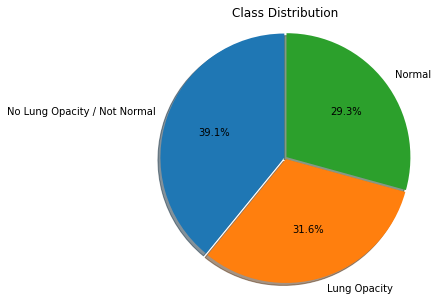

In [ ]:
label_count=merged_df['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [ ]:
print('Total records with Lung Opacity: ', merged_df[merged_df['class'] == 'Lung Opacity']['class'].count())
print('Total records with No Lung Opacity / Not Normal: ', merged_df[merged_df['class'] == 'No Lung Opacity / Not Normal']['class'].count())
print('Total Normal records: ', merged_df[merged_df['class'] == 'Normal']['class'].count())

Total records with Lung Opacity:  9555
Total records with No Lung Opacity / Not Normal:  11821
Total Normal records:  8851


**Observation:**

The above graph shows total numbers of records of different classes.
From the above graph, it shows that patients with No Lung Opacity/ Not Normal are highest as compare to Lung Opacity and Normal patients.

8,851 (29.3%) records does not have any diesaes

9,555 (31.6%) records has Lung Opacity

11,821 (39.1%) records hs No Lung Opacity / Not Normal

##### **2. Target to Class**

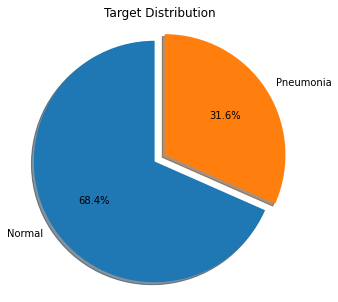

In [ ]:
# lets take a look at our Target Distribution
label_count=merged_df['Target'].value_counts()
explode = (0.1,0.0)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=['Normal','Pneumonia'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

**Observation:**

From the above graph, we can understand that 31.6% people got Pneumonia and 68.4% are Non-Pneumonia category.

#####**3. Impact of patient's age on pneumonia**

In [ ]:
age_list, sex_list, vp_list, studyid_list = [], [], [], []

merged_df['patientAge'] = 0
merged_df['patientSex'] = ''
merged_df['ViewPosition'] = ''
merged_df['StudyID'] = ''
counter = 0
for value in merged_df['patientId']:
  counter = counter + 1
  print(counter)
  patient_Target = (pd.to_numeric(merged_df[merged_df['patientId'] == value]['Target'],downcast ='signed', errors='coerce')) < 1
  dcm_patientFile = root_path + '/stage_2_train_images/%s.dcm' % value
  dcm_patientData = pyd.read_file(dcm_patientFile)
  age_list.append(dcm_patientData.PatientAge)
  sex_list.append(dcm_patientData.PatientSex)
  vp_list.append(dcm_patientData.ViewPosition)
  studyid_list.append(dcm_patientData.StudyID)

merged_df['patientAge'] = age_list
merged_df['patientSex'] = sex_list
merged_df['ViewPosition'] = vp_list
merged_df['StudyID'] = studyid_list
   
merged_df.head(10)

Streaming output truncated to the last 5000 lines.
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
2

patientId  ... StudyID
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...        
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...        
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...        
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...        
4  00436515-870c-4b36-a041-de91049b9ab4  ...        
5  00436515-870c-4b36-a041-de91049b9ab4  ...        
6  00569f44-917d-4c86-a842-81832af98c30  ...        
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  ...        
8  00704310-78a8-4b38-8475-49f4573b2dbb  ...        
9  00704310-78a8-4b38-8475-49f4573b2dbb  ...        

[10 rows x 11 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


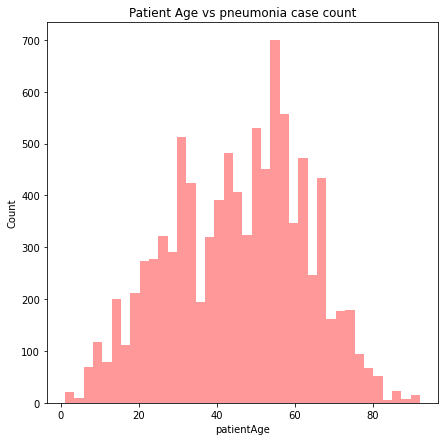

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
pneumonia_on_age = sns.distplot(merged_df[merged_df['Target']==1]['patientAge'], hist=True, kde=False, color='red', label='Target 1')
pneumonia_count = pneumonia_on_age.set_ylabel('Count')
pneumonia_count = pneumonia_on_age.set_title('Patient Age vs pneumonia case count')

**Observation:**
*   The above graph shows relation between pneumonia and patient's age.
*   There are more numbers of pneumonia patients between 40 to 60 age.




##### **4. Relation between patient's age and different classes**

**Normal Data Distribution**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


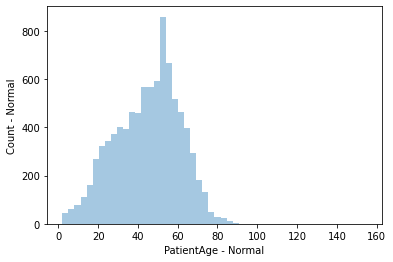

In [ ]:
n = sns.distplot(merged_df[merged_df['class']=='Normal']['patientAge'], hist=True, kde=False)
normal = n.set_ylabel('Count - Normal')
normal = n.set_xlabel('PatientAge - Normal')

From the above graph, age between 40-60 shows more normal

**No Lung Opacity / Not Normal Data Distribution**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


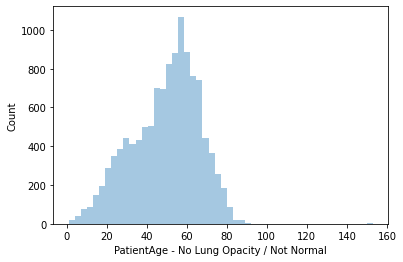

In [ ]:
not_normal = sns.distplot(merged_df[merged_df['class']=='No Lung Opacity / Not Normal']['patientAge'], hist=True, kde=False)
not_normal_data = not_normal.set_ylabel('Count')
not_normal_data = not_normal.set_xlabel('PatientAge - No Lung Opacity / Not Normal')

**Observation:**
Above graph shows that the patient's age between 40-60 have more number of cases.

**Lung Opacity Data Distribution**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


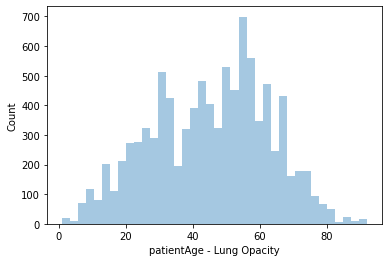

In [ ]:
lung_opacity = sns.distplot(merged_df[merged_df['class']=='Lung Opacity']['patientAge'], hist=True, kde=False)
lung_opacity_data = lung_opacity.set_ylabel('Count')
lung_opacity_data = lung_opacity.set_xlabel('patientAge - Lung Opacity')

**Observation:**

From the above graph, clearly visisble that there are more patients between age 40-60 age.

##### **5. Data Distribution on Patient Gender**

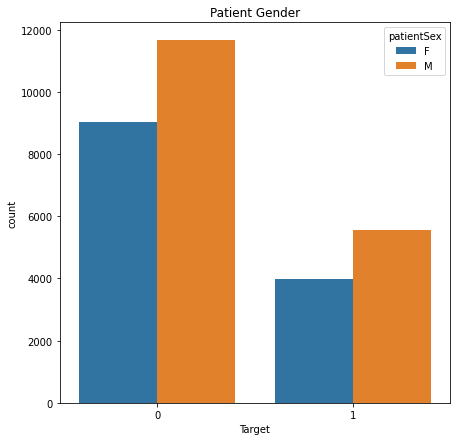

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
gender = sns.countplot(x='Target', hue='patientSex', data=merged_df)
gender_data = gender.set_title('Patient Gender')

##### **6. Different classes as per Patient Gender**

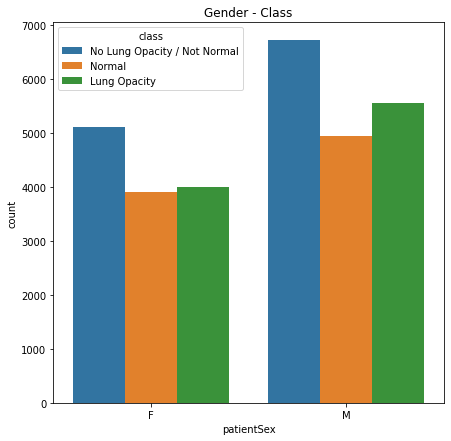

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
gender_class = sns.countplot(x='patientSex', hue='class', data=merged_df)
gender_class_data = gender_class.set_title('Gender - Class')

**Observation:**

Male patients have more records for different classes.

#####**7. Impact on Age and Gender**

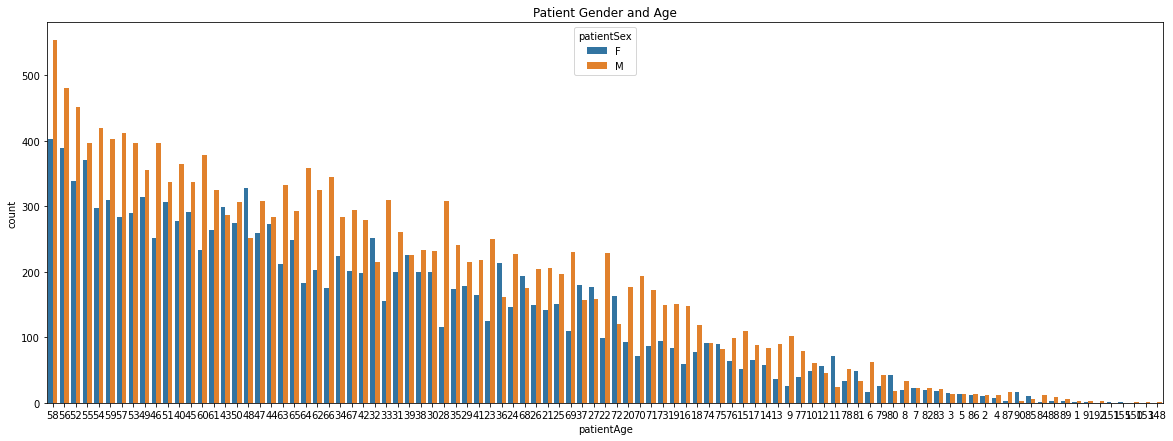

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 7))
gender_comp = sns.countplot(x='patientAge', hue='patientSex', data=merged_df, order=merged_df['patientAge'].value_counts().index)
gender_data = gender_comp.set_title('Patient Gender and Age')

##### **8. Age and Pneumonia relation**

In [ ]:
target_data = merged_df[merged_df['Target']==1]
print(target_data.shape)
target_sample = target_data.sample(9555)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2

(9555, 11)


In [ ]:
target_sample['patientAge'] = target_sample['patientAge'].astype(int)
target_age1 = target_sample[target_sample['patientAge'] < 20]
target_age2 = target_sample[(target_sample['patientAge'] >=20) & (target_sample['patientAge'] < 35)]
target_age3 = target_sample[(target_sample['patientAge'] >=35) & (target_sample['patientAge'] < 50)]
target_age4 = target_sample[(target_sample['patientAge'] >=50) & (target_sample['patientAge'] < 65)]
target_age5 = target_sample[target_sample['patientAge'] >= 65]

In [ ]:
def plot_data(data,color_point, color_window,text):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plt.title("Centers of Lung Opacity rectangles over rectangles\n{}".format(text))
    data.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color=color_point)
    for i, crt_sample in data.iterrows():
        ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
            width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color=color_window))
    plt.show()

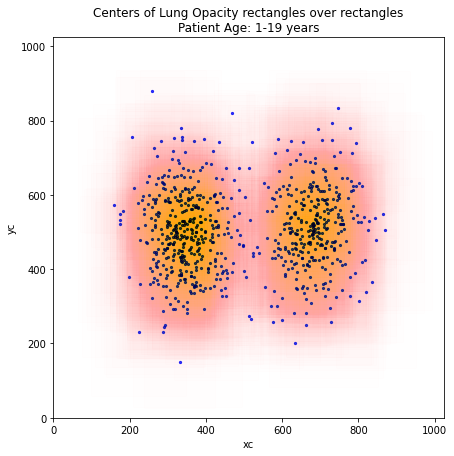

In [ ]:
plot_data(target_age1,'blue', 'Orange', 'Patient Age: 1-19 years')

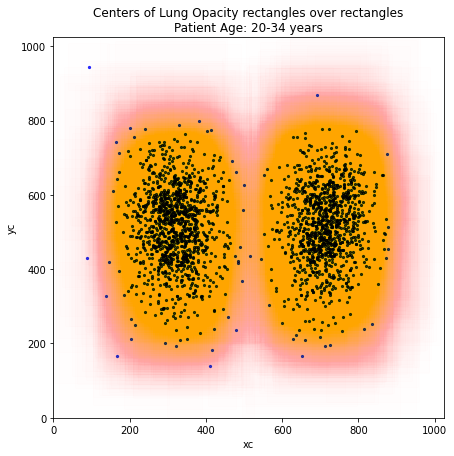

In [ ]:
plot_data(target_age2,'blue', 'Orange', 'Patient Age: 20-34 years')

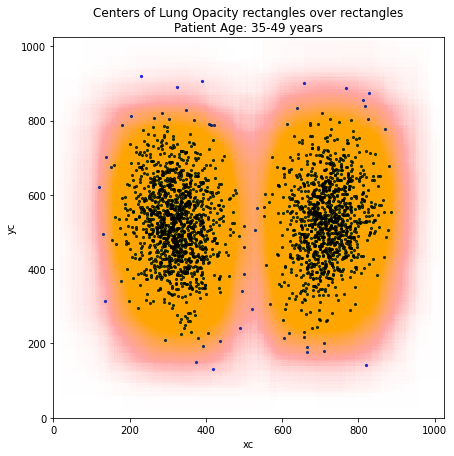

In [ ]:
plot_data(target_age3,'blue', 'orange', 'Patient Age: 35-49 years')

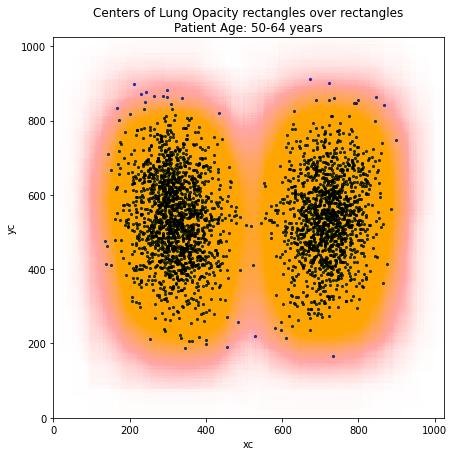

In [ ]:
plot_data(target_age4,'blue', 'orange', 'Patient Age: 50-64 years')

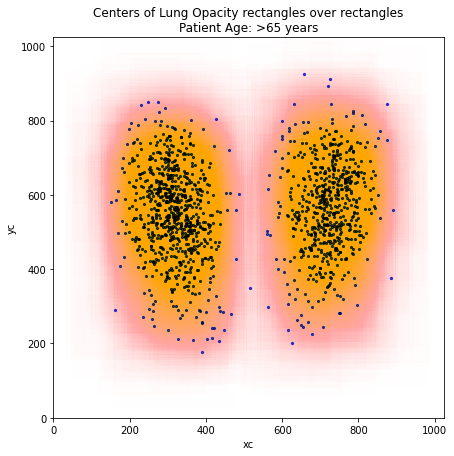

In [ ]:
plot_data(target_age5,'blue', 'orange', 'Patient Age: >65 years')

**Observation:**

From the above graphs, we can clearly understands that patients age between 50 to 65 has more cases of Pneumonia.

##### **9. View position on different features**

**Class**

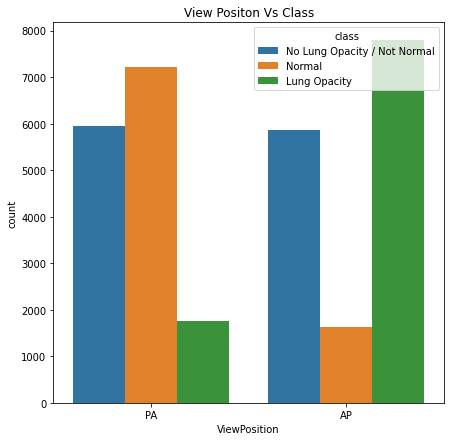

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
view_position_class = sns.countplot(x='ViewPosition', hue='class', data=merged_df)
view_position_class_data = view_position_class.set_title('View Positon Vs Class')

**Observation:**

Patient's with AP view position has more number of records.

**Target**

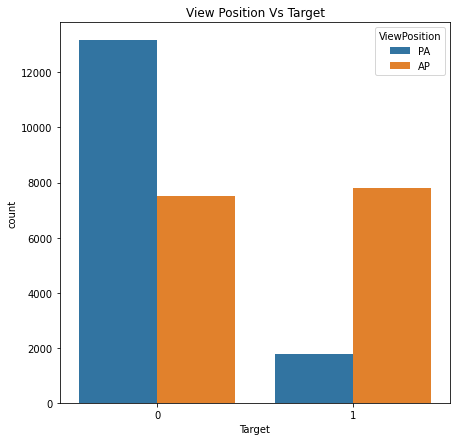

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
view_position_target = sns.countplot(x='Target', hue='ViewPosition', data=merged_df)
view_position_target_data = view_position_target.set_title('View Position Vs Target')

**Observation:**

Patient with AP view position has more number of records then PA.

**Gender Wise**

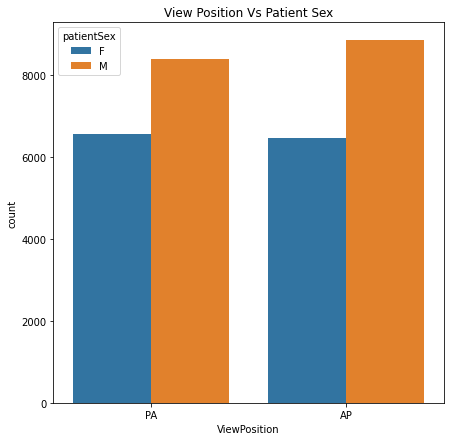

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
view_position_gender = sns.countplot(x='ViewPosition', hue='patientSex', data=merged_df)
view_position_gender_data = view_position_gender.set_title('View Position Vs Patient Sex')

**Observation:**

Patient with AP view position has more records then PA.

**Age wise**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


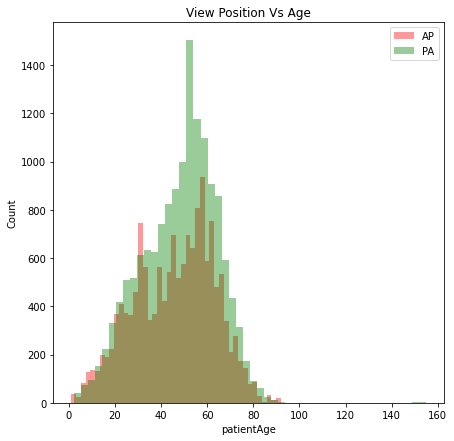

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))

age_data = sns.distplot(merged_df[merged_df['ViewPosition']=='AP']['patientAge'], hist=True, kde=False, color='red', label='AP')
age_data = sns.distplot(merged_df[merged_df['ViewPosition']=='PA']['patientAge'], hist=True, kde=False, color='green', label='PA')
view_position_age_count_ = age_data.set_ylabel('Count')
view_position_age_count_ = age_data.legend()
view_position_age_count_ = age_data.set_title('View Position Vs Age')

**Observation:**

It clearly shows AP view position has more numbers of records then PA.

##### **1. Image Loading - Plotting different X-Rays**

In [ ]:
# Function to Read DCM Image
def read_image(patientId):
    train_fp = root_path + '/stage_2_train_images/%s.dcm' % patientId
    dcm = pydicom.read_file(train_fp)
    return dcm

In [ ]:
def image_grid(df, pid_sample_list, nrows=3, ncols=3, draw_bbox=True, ax_off=True):
    fig = plt.figure(figsize=(16, 12))
    for i in range(nrows * ncols):
        patient_id = pid_sample_list[i]
        img = read_image(patient_id).pixel_array
        ax = fig.add_subplot(nrows, ncols, i + 1)
        plt.imshow(img, cmap='gray')
        ax.set_title(patient_id)
        if ax_off: 
            ax.set_axis_off()
        if draw_bbox:
            bbox_rows = merged_df[merged_df['patientId'] == patient_id]
            for _, row in bbox_rows.iterrows():
                x, y = row['x'], row['y']
                width, height = row['width'], row['height']
                bbox = patches.Rectangle((x, y), width, height, linewidth=.5, edgecolor='r', facecolor='none')
                ax.add_patch(bbox)
    plt.tight_layout()
    plt.subplots_adjust(wspace=.01, hspace=.01)
    return fig

Label: No Lung Opacity / Not Normal
0004cfab-14fd-4e49-80ba-63a80b6bddd6


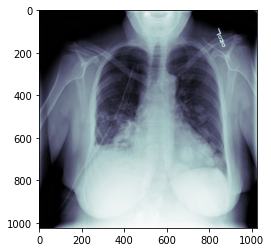

In [ ]:
# DICOM image with class label "No Lung Opacity / Not Normal"

print('Label: No Lung Opacity / Not Normal')
print(label_meta_data['patientId'][0])

filename = label_meta_data['patientId'][0] + '.dcm'
filename = (os.path.join(root_path,'stage_2_train_images',filename))

dataset = pyd.dcmread(filename)

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

Label: Normal
003d8fa0-6bf1-40ed-b54c-ac657f8495c5


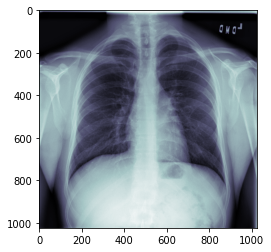

In [ ]:
# DICOM image with class label "Normal"

print('Label: Normal')
print(label_meta_data['patientId'][3])

filename = label_meta_data['patientId'][3] + '.dcm'
filename = (os.path.join(root_path,'stage_2_train_images',filename))

dataset = pyd.dcmread(filename)

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

Label: Lung Opacity
00436515-870c-4b36-a041-de91049b9ab4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


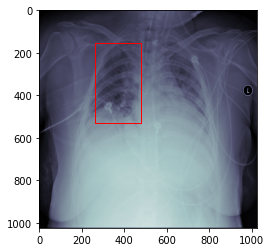

In [ ]:
# DICOM image with class label "Lung Opacity"

from matplotlib.patches import Rectangle

print('Label: Lung Opacity')
print(train_labels_df['patientId'][4])

filename = train_labels_df['patientId'][4] + '.dcm'
filename = (os.path.join(root_path,'stage_2_train_images',filename))

dataset = pyd.dcmread(filename)

plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)

bb = Rectangle((train_labels_df['x'][4], train_labels_df['y'][4]), train_labels_df['width'][4], train_labels_df['height'][4], fill=False, color='red')

plt.axes().add_patch(bb)
plt.show()

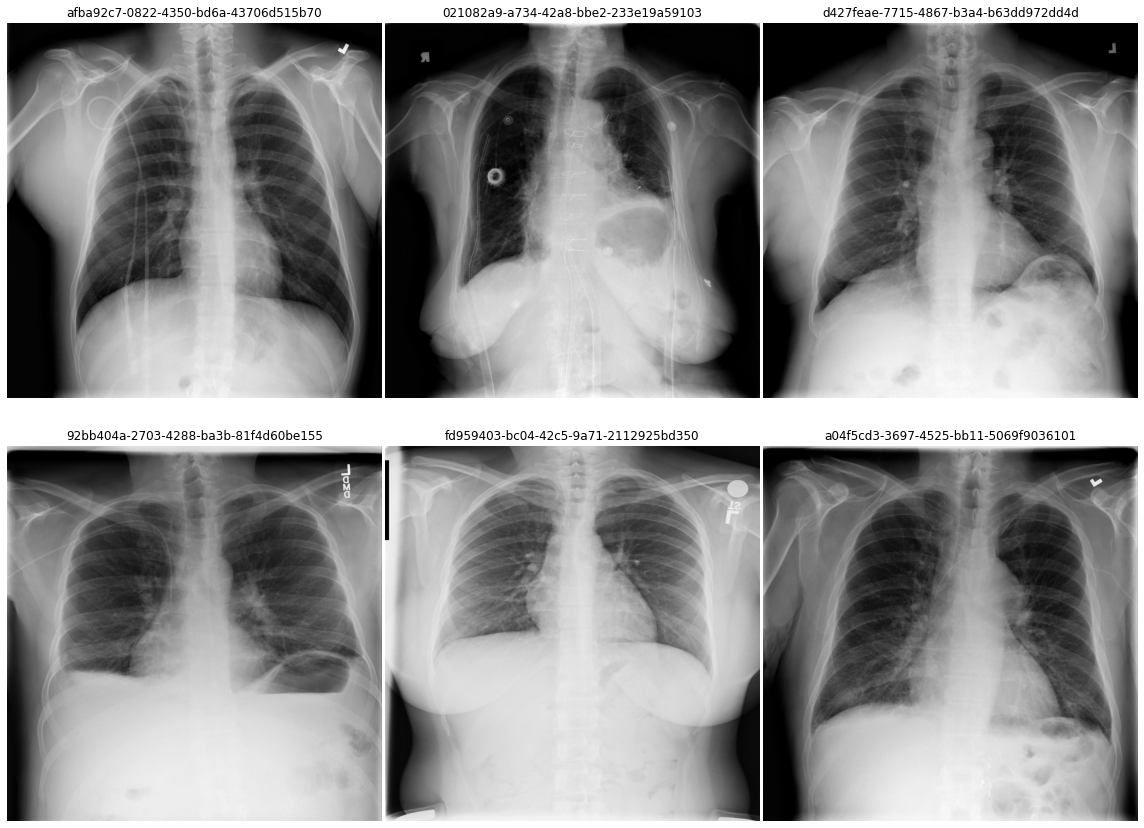

In [ ]:
import pydicom
patient_ids = merged_df[merged_df['ViewPosition']=='PA']['patientId'].sample(20).tolist()
patient_ids_grid = image_grid(merged_df, patient_ids, nrows=2, ncols=3)

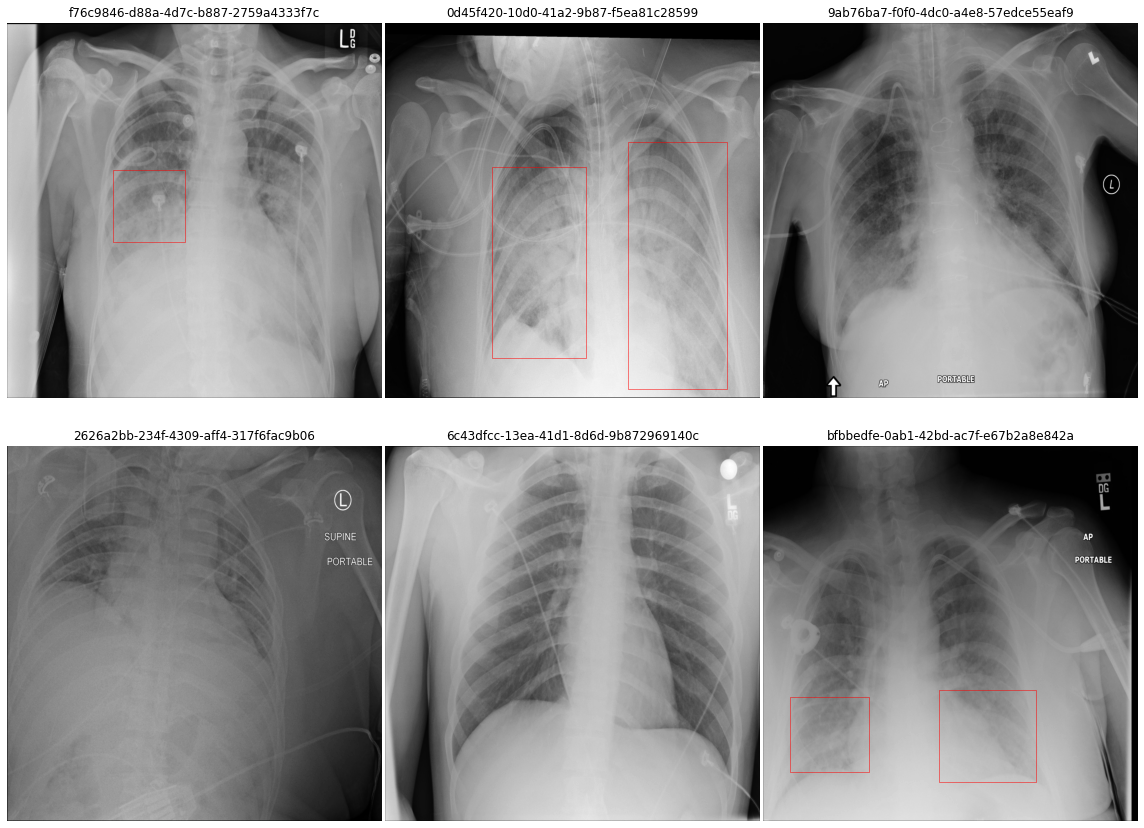

In [ ]:
patient_ids = merged_df[merged_df['ViewPosition']=='AP']['patientId'].sample(20).tolist()
patient_ids_grid = image_grid(merged_df, patient_ids, nrows=2, ncols=3)

##### **2. Heat Maps with Bounding Boxes**

In [ ]:
from functools import partial

In [ ]:
def build_bbox_arrays_id(df):
    arrayConstructor = partial(np.zeros, shape=(1024,1024), dtype=np.uint8)
    arrays = defaultdict(arrayConstructor)
    for idx, row in df.iterrows():
        patient_id = row['patientId']
        x, y = int(row['x']), int(row['y'])
        width, height = int(row['width']), int(row['height'])
        array = arrays[patient_id]
        array[y: y + height, x: x + width] += 1
    return arrays

In [ ]:
bbox_arrays = build_bbox_arrays_id(merged_df[merged_df['Target']==1])

In [ ]:
df_labels = merged_df.copy(deep=True)
bbox_counts = df_labels.groupby('patientId')['Target'].sum()
df_labels.index = df_labels.patientId
df_labels['bbox_counts'] = bbox_counts
df_labels = df_labels.reset_index(drop=True)

In [ ]:
merged_df['patientAge'] = merged_df['patientAge'].astype(int)
patient_bbox_ids = {
    'pa': set(merged_df['patientId'][merged_df['ViewPosition']=='PA'].dropna().unique()),
    'ap': set(merged_df['patientId'][merged_df['ViewPosition']=='AP'].dropna().unique()),
    
    'bbox_4': set(df_labels['patientId'][df_labels['bbox_counts']==4].dropna().unique()),
    'bbox_3': set(df_labels['patientId'][df_labels['bbox_counts']==3].dropna().unique()),
    'bbox_2': set(df_labels['patientId'][df_labels['bbox_counts']==2].dropna().unique()),
    'bbox_1': set(df_labels['patientId'][df_labels['bbox_counts']==1].dropna().unique()),
    
    'f': set(merged_df['patientId'][merged_df['patientSex']=='F'].dropna().unique()),
    'm': set(merged_df['patientId'][merged_df['patientSex']=='M'].dropna().unique()),
    
    'age_above_60': set(merged_df['patientId'][merged_df['patientAge'] > 60].dropna().unique()),
    'age_40_to_60': set(merged_df['patientId'][(merged_df['patientAge'] <= 60) & (merged_df['patientAge'] >= 40)].dropna().unique()),
    'age_below_40': set(merged_df['patientId'][merged_df['patientAge'] < 40].dropna().unique()),
}

In [ ]:
def_array = partial(np.zeros, shape=(1024,1024), dtype=np.uint32)
bbox_groups = defaultdict(def_array)
bbox_groups['all'] = np.zeros(shape=(1024,1024), dtype=np.uint32)

for patient_id, bbox_array in bbox_arrays.items():
    # add to all group
    bbox_groups['all'] += bbox_array

    # add to each other group where id is in that group's id set
    for group, id_set in patient_bbox_ids.items():
        if patient_id in id_set:
            bbox_groups[group] += bbox_array

In [ ]:
def graph_density(array, ax, title, n_countour_levels=3):
    contour_set = ax.contour(
        np.arange(0, 1024, 1), 
        np.arange(1024, 0, -1),
        array, 
        n_countour_levels, 
        linewidths=.5,
        colors='black'
    )
    plt.clabel(contour_set, inline=True, fontsize=10, fmt='%.0f')

    im = ax.imshow(
        array, 
        extent=[0, 1024, 0, 1024], 
        origin='upper', 
        cmap='viridis', 
        alpha=.8
    )
    plt.colorbar(im, ax=ax)
    ax.set_title(title)
    return im

##### **3. Drawing the Heat Maps**

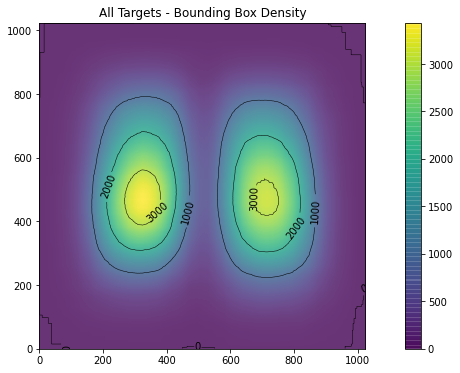

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharex=True)
bbox_all_targets = graph_density(bbox_groups['all'], axes, 'All Targets - Bounding Box Density')

**Observation:**

Above heat map depicts high level view of overall Pneumonia cases

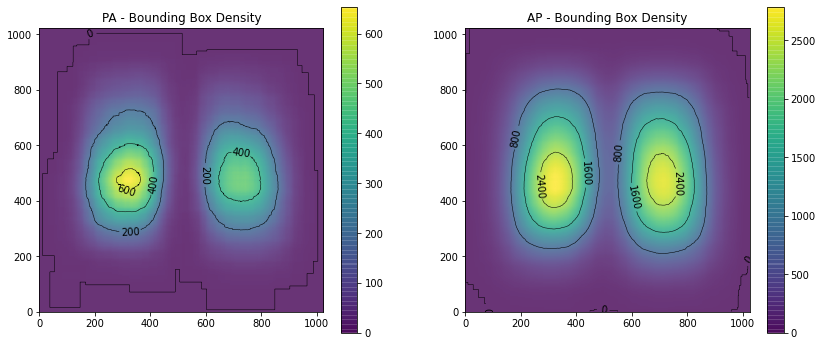

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

pa_bounding_box = graph_density(bbox_groups['pa'], axes[0], 'PA - Bounding Box Density')
ap_bounding_box = graph_density(bbox_groups['ap'], axes[1], 'AP - Bounding Box Density')

**Observation:**

From the above heat map, we can clearly understand that AP position have more Pneumonia cases that PA position.

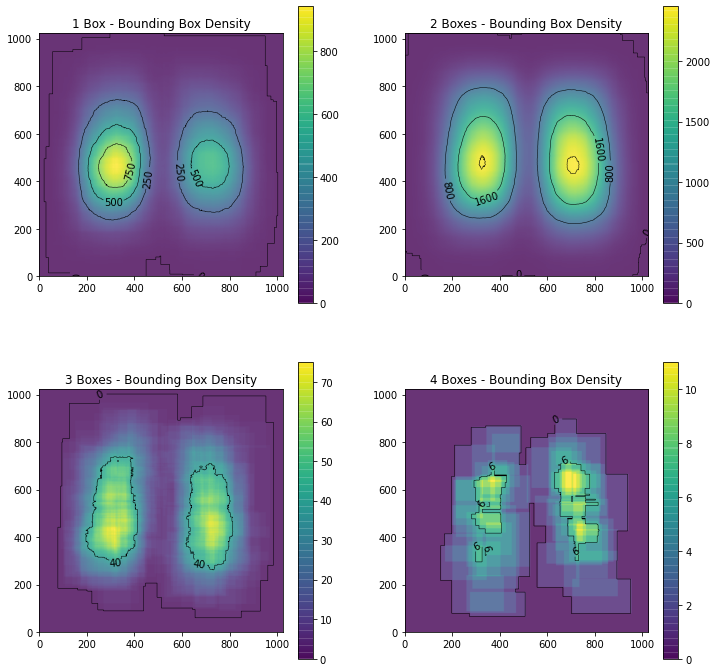

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

bbox_1 = graph_density(bbox_groups['bbox_1'], axes[0, 0], '1 Box - Bounding Box Density', n_countour_levels=3)
bbox_2 = graph_density(bbox_groups['bbox_2'], axes[0, 1], '2 Boxes - Bounding Box Density', n_countour_levels=3)
bbox_3 = graph_density(bbox_groups['bbox_3'], axes[1, 0], '3 Boxes - Bounding Box Density', n_countour_levels=1)
bbox_4 = graph_density(bbox_groups['bbox_4'], axes[1, 1], '4 Boxes - Bounding Box Density', n_countour_levels=1)

**Observation:**

From the above heat map, we can clearly understands that 2 bounding boxes has more Pneumonia count than others

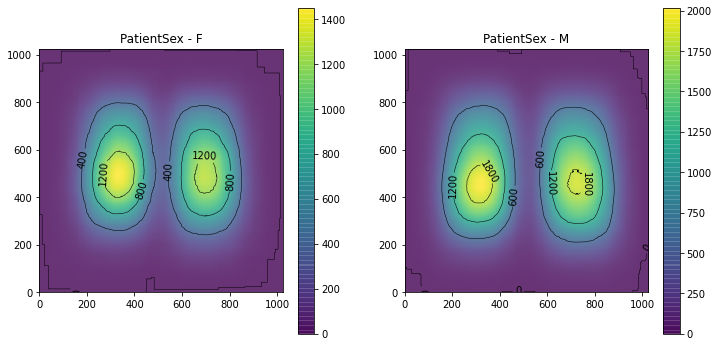

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

bbox_f = graph_density(bbox_groups['f'], axes[0], 'PatientSex - F', n_countour_levels=3)
bbox_m = graph_density(bbox_groups['m'], axes[1], 'PatientSex - M', n_countour_levels=3)

**Observation:**

From the above heat maps, we can clearly understand that Male patients has more Pneumonia than Female.

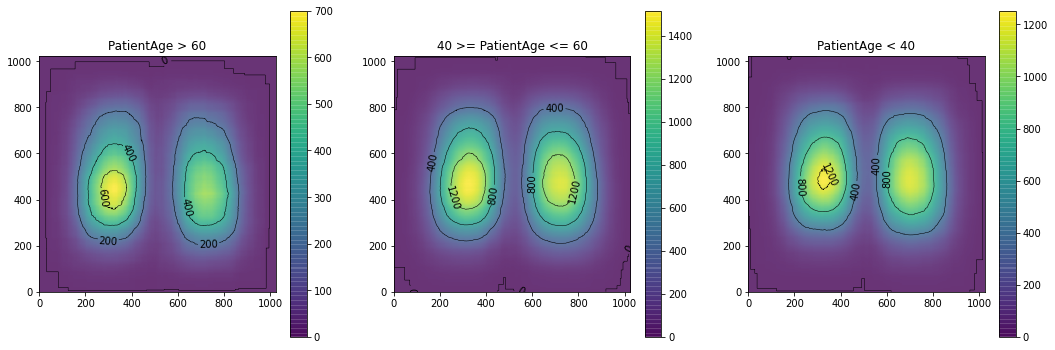

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

bbox_age_above_60 = graph_density(bbox_groups['age_above_60'], axes[0], 'PatientAge > 60', n_countour_levels=3)
bbox_age_40_to_60 = graph_density(bbox_groups['age_40_to_60'], axes[1], '40 >= PatientAge <= 60', n_countour_levels=3)
bbox_age_below_40 = graph_density(bbox_groups['age_below_40'], axes[2], 'PatientAge < 40', n_countour_levels=3)

**Observation:**

From the above heat maps, its clear that Pneumonia is infected age between 40 and 60.

## **Model Building**

In [ ]:
# Splitting into training and validation dataset for input into data generator functions

from sklearn.model_selection import train_test_split

df = merged_df[['patientId','Target']]
df = df.drop_duplicates()

patientId = df['patientId']
Target = df['Target']

#X_train, X_val, Y_train, Y_val = train_test_split(patientId,Target, test_size=0.2, random_state=7)
#X_train, X_val, Y_train, Y_val = train_test_split(patientId,Target, test_size=0.3, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(patientId,Target, test_size=0.4, random_state=42)
# Print the distribution of labels between the training and validation dataset
print("Ratio of Pnuemonia to Non-Pnuemonia Labels in training dataset is: {}".format(round(Y_train.value_counts()[1] \
                                                                                         /len(Y_train),2)))
print("Ratio of Pnuemonia to Non-Pnuemonia Labels in validation dataset is: {}".format(round(Y_val.value_counts()[1] \
                                                                                         /len(Y_val),2)))
print("No. of records in training dataset is: {}".format(len(X_train)))
print("No. of records in validation dataset is: {}".format(len(X_val)))

Ratio of Pnuemonia to Non-Pnuemonia Labels in training dataset is: 0.22
Ratio of Pnuemonia to Non-Pnuemonia Labels in validation dataset is: 0.23
No. of records in training dataset is: 16010
No. of records in validation dataset is: 10674


**Data Processing**

Extract Data from DICOM file

In [ ]:
merged_df_sample = merged_df.sample(n=26000) 

In [ ]:
temp_data_directory = root_path + 'working_data' 
print(temp_data_directory)
#os.mkdir(f'{temp_data_directory}')
#os.mkdir(f'{temp_data_directory}/positive')
#os.mkdir(f'{temp_data_directory}/negative')

/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data


In [ ]:
for value in merged_df_sample['patientId']:
  !cp '/content/drive/MyDrive/AI_ML_Projects/Capstone Project/stage_2_train_images/{value}.dcm' '/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data/'

In [ ]:
merged_df_sample['path']=f'{temp_data_directory}'+'/'+merged_df_sample['patientId'].astype(str)+'.dcm'
print(temp_data_directory)
#print(path)

/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data


In [ ]:
age_list, sex_list, vp_list, studyid_list = [], [], [], []

merged_df_sample['age'] = 0
merged_df_sample['sex'] = ''
merged_df_sample['ViewPosition'] = ''
merged_df_sample['StudyID'] = ''
counter = 0
for value in merged_df_sample['patientId']:
  counter = counter + 1
  patient_Target = (pd.to_numeric(merged_df_sample[merged_df_sample['patientId'] == value]['Target'],downcast ='signed', errors='coerce')) < 1
  dcm_patientFile = root_path + '/stage_2_train_images/%s.dcm' % value
  dcm_patientData = pydicom.read_file(dcm_patientFile)
  age_list.append(dcm_patientData.PatientAge)
  sex_list.append(dcm_patientData.PatientSex)
  vp_list.append(dcm_patientData.ViewPosition)
  studyid_list.append(dcm_patientData.StudyID)

merged_df_sample['age'] = age_list
merged_df_sample['sex'] = sex_list
merged_df_sample['ViewPosition'] = vp_list
merged_df_sample['StudyID'] = studyid_list
   
merged_df_sample.head(10)

patientId  ... sex
5268   457e1b0b-89f5-4f7f-b752-fd8420414b97  ...   M
8823   62a0ba68-f504-4632-adc2-39495d6a77b8  ...   M
15682  98d4005a-2e90-4555-8354-686e3fa029bd  ...   F
13541  88035956-1e69-4f8f-a9cb-fc3c471b03d3  ...   M
21117  bf7225ea-722d-483c-8fd6-3118966ca7b1  ...   F
22287  c9af00ff-cb8e-4a84-8746-2dcc83835075  ...   M
5294   45bfcdbc-1669-4ce8-8d36-848bc4b0e40d  ...   M
28916  ff728586-b8a3-4d0f-8956-4b93dfc3b728  ...   F
23047  cfc6d411-d8cc-407d-9dd7-dfc5a0cc25b7  ...   M
26368  eb5be562-36b3-44b9-a7ef-68a49d4b03ac  ...   F

[10 rows x 14 columns]

In [ ]:
merged_df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 5268 to 28714
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patientId     26000 non-null  object 
 1   class         26000 non-null  object 
 2   x             8231 non-null   float64
 3   y             8231 non-null   float64
 4   width         8231 non-null   float64
 5   height        8231 non-null   float64
 6   Target        26000 non-null  int64  
 7   patientAge    26000 non-null  int64  
 8   patientSex    26000 non-null  object 
 9   ViewPosition  26000 non-null  object 
 10  StudyID       26000 non-null  object 
 11  path          26000 non-null  object 
 12  age           26000 non-null  object 
 13  sex           26000 non-null  object 
dtypes: float64(4), int64(2), object(8)
memory usage: 3.0+ MB


**Splitting Data into relative classes**

In [ ]:
negative_info=merged_df_sample[merged_df_sample['Target']==0]
print(len(negative_info))
negative_info.head()

17769


patientId  ... sex
8823   62a0ba68-f504-4632-adc2-39495d6a77b8  ...   M
15682  98d4005a-2e90-4555-8354-686e3fa029bd  ...   F
13541  88035956-1e69-4f8f-a9cb-fc3c471b03d3  ...   M
22287  c9af00ff-cb8e-4a84-8746-2dcc83835075  ...   M
5294   45bfcdbc-1669-4ce8-8d36-848bc4b0e40d  ...   M

[5 rows x 14 columns]

In [ ]:
positive_info=merged_df_sample[merged_df_sample['Target']==1]
unique_positive=positive_info[['path','patientId']]

#print(path)
path=unique_positive['path'].unique()
#print(path)
patientId=unique_positive['patientId'].unique()

In [ ]:
unique_positive=pd.DataFrame({'path':path,'patientId':patientId})
len(unique_positive)

5583

In [ ]:
from tqdm import tqdm
from skimage.transform import resize

for _,row in tqdm(unique_positive.iterrows()):
    img=pydicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave(f'/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data/positive/'+row['patientId']+'.jpg',img,cmap='gray')

5583it [06:32, 14.22it/s]


In [ ]:
negtive_info=merged_df_sample[merged_df_sample['Target']==0]
negative=negative_info[['path','patientId']]

#print(path)
path=negative['path'].unique()
#print(path)
patientId=negative['patientId'].unique()

In [ ]:
negative=pd.DataFrame({'path':path,'patientId':patientId})
len(negative)

17769

In [ ]:
for _,row in tqdm(negative.iterrows()):
    img=pydicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave(f'/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data/negative/'+row['patientId']+'.jpg',img,cmap='gray')

17769it [21:23, 13.84it/s]


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input

In [ ]:
datagen=ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,
                          width_shift_range=0.05,rescale=1/255,fill_mode='nearest',height_shift_range=0.05,
                           preprocessing_function=preprocess_input,validation_split=0.1,
                          )

In [ ]:
train=datagen.flow_from_directory('/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data',color_mode='rgb',batch_size=128,class_mode='binary',subset='training')
test=datagen.flow_from_directory('/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data',color_mode='rgb',batch_size=32,class_mode='binary',subset='validation')

Found 21018 images belonging to 2 classes.
Found 2334 images belonging to 2 classes.


In [ ]:
train.class_indices

{'negative': 0, 'positive': 1}

##### **UNet**

In [ ]:
# Creating 64 x 64 mask numpy arrays for each DICOM image and storing in a separate folder

i = 1
for index, row in merged_df.iterrows():

  mask_array = np.zeros((64, 64))
  mask_path_npy = row['patientId'] + '.npy'

  merged_df['x'] = merged_df['x'].fillna(0).astype(int)
  merged_df['y'] = merged_df['y'].fillna(0).astype(int)
  merged_df['width'] = merged_df['width'].fillna(0).astype(int)
  merged_df['height'] = merged_df['height'].fillna(0).astype(int)
  
  merged_df['x'] = merged_df['x']
  merged_df['y'] = merged_df['y']
  merged_df['width'] = merged_df['width']
  merged_df['height'] = merged_df['height']
  
  x1 = int(row['x'] // 16)
  y1 = int(row['y'] // 16)
  width = int(row['width'] // 16)
  height = int(row['height'] // 16)
  x2 = x1 + width
  y2 = y1 + height
  mask_array[y1:y2, x1:x2] = 1

  mask_file_path = os.path.join(root_path,'training_masks_64')

  np.save(os.path.join(mask_file_path,mask_path_npy),mask_array)
  del mask_array
  i +=1
  if i % 100 == 0:
    print( str(100 * i / len(merged_df)) + "% completed")
  elif i == len(merged_df):
    print("100% completed")

0.33083005260197834% completed
0.6616601052039567% completed
0.9924901578059351% completed
1.3233202104079134% completed
1.6541502630098919% completed
1.9849803156118702% completed
2.3158103682138487% completed
2.6466404208158267% completed
2.9774704734178052% completed
3.3083005260197837% completed
3.639130578621762% completed
3.9699606312237403% completed
4.300790683825719% completed
4.631620736427697% completed
4.962450789029676% completed
5.2932808416316535% completed
5.624110894233632% completed
5.9549409468356105% completed
6.285770999437589% completed
6.6166010520395675% completed
6.947431104641546% completed
7.278261157243524% completed
7.609091209845502% completed
7.939921262447481% completed
8.27075131504946% completed
8.601581367651438% completed
8.932411420253416% completed
9.263241472855395% completed
9.594071525457373% completed
9.924901578059352% completed
10.255731630661328% completed
10.586561683263307% completed
10.917391735865285% completed
11.248221788467264% comple

In [279]:
# DataGenerator custom function for 64 x 64 image

import math
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow as tf

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 128
class DataGenerator(Sequence):

    def __init__(self, data_list):
        self.paths = []
        self.mask = np.zeros((len(data_list), IMAGE_HEIGHT, IMAGE_WIDTH))
          
        for i,d in enumerate(data_list):
          try:
            path = "stage_2_train_images/" + d + ".dcm"
            path_mask = "training_masks_64/" + d + ".npy"

            mask_img = np.load(path_mask)
            self.mask[i,:,:] = mask_img
            del mask_img
            self.paths.append(path)
          except:
            pass

    def __len__(self):
        return math.ceil(len(self.mask) / BATCH_SIZE)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_masks = self.mask[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]

        batch_images = np.zeros((len(batch_paths), IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
          img = pydicom.dcmread(f)
          img_ds = img.pixel_array[::16, ::16]
          img_ds = tf.reshape(img_ds, [IMAGE_HEIGHT,IMAGE_WIDTH,1])
          img_ds = tf.image.grayscale_to_rgb(img_ds)
          batch_images[i] = preprocess_input(np.array(img_ds, dtype=np.float32))
        
        return (batch_images, batch_masks)

In [280]:
# Splitting into training and validation dataset for input into data generator functions

from sklearn.model_selection import train_test_split

df = merged_df[['patientId','Target']]
df = df.drop_duplicates()

patientId = df['patientId']
Target = df['Target']

#X_train, X_val, Y_train, Y_val = train_test_split(patientId,Target, test_size=0.2, random_state=7)
#X_train, X_val, Y_train, Y_val = train_test_split(patientId,Target, test_size=0.3, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(patientId,Target, test_size=0.4, random_state=42)
# Print the distribution of labels between the training and validation dataset
print("Ratio of Pnuemonia to Non-Pnuemonia Labels in training dataset is: {}".format(round(Y_train.value_counts()[1] \
                                                                                         /len(Y_train),2)))
print("Ratio of Pnuemonia to Non-Pnuemonia Labels in validation dataset is: {}".format(round(Y_val.value_counts()[1] \
                                                                                         /len(Y_val),2)))
print("No. of records in training dataset is: {}".format(len(X_train)))
print("No. of records in validation dataset is: {}".format(len(X_val)))

Ratio of Pnuemonia to Non-Pnuemonia Labels in training dataset is: 0.22
Ratio of Pnuemonia to Non-Pnuemonia Labels in validation dataset is: 0.23
No. of records in training dataset is: 16010
No. of records in validation dataset is: 10674


In [281]:
# my Model using U-Net

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import Input

ALPHA = 1.0
h = 64

def create_model(trainable=True):
    #model = MobileNet(input_shape=(h, h, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    model = MobileNet(input_tensor = Input(shape = (h, h, 3)), include_top=False, alpha=ALPHA, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
  
    block_1 = model.get_layer("conv_pw_1_relu").output
    block0 = model.get_layer("conv_pw_3_relu").output
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block_1])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((h, h))(x)
    print(x.shape)
    return Model(inputs=model.input, outputs=x)

# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable=True)

# Print summary
model.summary()

(?, 4, 4, 1536)
(?, 8, 8, 1792)
(?, 16, 16, 1920)
(?, 32, 32, 1984)
(?, 64, 64, 1984)
(?, 64, 64)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 32, 32, 32)   0           conv1_bn[0][0]             

In [282]:
# Custom function IOU as per Step 5 below

import tensorflow.keras.backend as K

def iou(boxA,boxB):

    xA = K.stack([boxA[:,0], boxB[:,0]], axis=-1)
    yA = K.stack([boxA[:,1], boxB[:,1]], axis=-1)
    xB = K.stack([boxA[:,2], boxB[:,2]], axis=-1)
    yB = K.stack([boxA[:,3], boxB[:,3]], axis=-1)

    xA = K.max(xA, axis=-1)
    yA = K.max(yA, axis=-1)
    xB = K.min(xB, axis=-1)
    yB = K.min(yB, axis=-1)

    interX = K.zeros_like(xB)
    interY = K.zeros_like(yB)

    interX = K.stack([interX, xB-xA + 1], axis=-1)
    interY = K.stack([interY, yB-yA + 1], axis=-1)

    #because of these "max", interArea may be constant 0, without gradients, and you may have problems with no gradients. 
    interX = K.max(interX, axis=-1)
    interY = K.max(interY, axis=-1)
    interArea = interX * interY

    boxAArea = (boxA[:,2] - boxA[:,0] + 1) * (boxA[:,3] - boxA[:,1] + 1)    
    boxBArea = (boxB[:,2] - boxB[:,0] + 1) * (boxB[:,3] - boxB[:,1] + 1) 

    iou = interArea / (boxAArea + boxBArea - interArea)

    return iou

In [283]:
# Compile the model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanSquaredError
import tensorflow as tf
#run_opts = tf.compat.RunOptions(report_tensor_allocations_upon_oom = True)
#run_opts = tf.compat.v1.RunOptions()

optimizer = Adam(lr=0.001)
"""
optimizer = Adam(lr=0.01)
optimizer = Adam(lr=0.1)

optimizer = SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
optimizer = SGD(learning_rate=0.001, momentum=0.05, nesterov=False)
optimizer = SGD(learning_rate=0.001, momentum=0.0, nesterov=True)
optimizer = SGD(learning_rate=0.001, momentum=0.05, nesterov=True) # Not needed as prior variants did not improve the data

RMSprop(learning_rate=0.001)
RMSprop(learning_rate=0.01)
RMSprop(learning_rate=0.1)
"""
model.compile(loss='mse', optimizer=optimizer, metrics=[MeanIoU(num_classes=2),'accuracy',MeanSquaredError(), iou])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [284]:
# EarlyStopping feature

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("Adam model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=3, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode="min")

In [285]:
# Creating DataGenerator for test of 1st iteration of model

train_datagen = DataGenerator(X_train)
val_datagen = DataGenerator(X_val)

In [288]:
# Fitting the model
import pydicom

model.fit(train_datagen,epochs=20,callbacks=[reduce_lr],steps_per_epoch=100,validation_data=val_datagen)

Epoch 1/20


TypeError: ignored

##### **VGG19**

In [ ]:
pre_trained_model = VGG19(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

80150528/80134624 [==============================] - 1s 0us/step
last layer output shape:  (None, 8, 8, 512)


In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU,GaussianDropout

model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.25)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [ ]:
from tensorflow.keras.models import Model


vgg19model = Model( pre_trained_model.input, model) 

vgg19model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early=EarlyStopping(monitor='accuracy',patience=3,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [ ]:
class_weight={0:1,1:3.3}

In [ ]:
vgg19model.fit(train,epochs=20,callbacks=[reduce_lr],steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 251s 2s/step - loss: 1.0986 - accuracy: 0.6772 - val_loss: 0.4106 - val_accuracy: 0.8176
Epoch 2/20
100/100 [==============================] - 230s 2s/step - loss: 0.8458 - accuracy: 0.7204 - val_loss: 0.4638 - val_accuracy: 0.7716
Epoch 3/20
100/100 [==============================] - 228s 2s/step - loss: 0.7819 - accuracy: 0.7347 - val_loss: 0.4092 - val_accuracy: 0.8057
Epoch 4/20
100/100 [==============================] - 230s 2s/step - loss: 0.7526 - accuracy: 0.7495 - val_loss: 0.3975 - val_accuracy: 0.8212
Epoch 5/20
100/100 [==============================] - 223s 2s/step - loss: 0.7520 - accuracy: 0.7397 - val_loss: 0.4548 - val_accuracy: 0.7933
Epoch 6/20
100/100 [==============================] - 218s 2s/step - loss: 0.7464 - accuracy: 0.7459 - val_loss: 0.3860 - val_accuracy: 0.8185

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
100/100 [==============================] - 225s 2s

**Save the Model**

In [ ]:
vgg19model.save('/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data/vgg19model.h5')

**Plotting Accuracy and Validation Accuracy**

<Figure size 2160x1440 with 0 Axes>

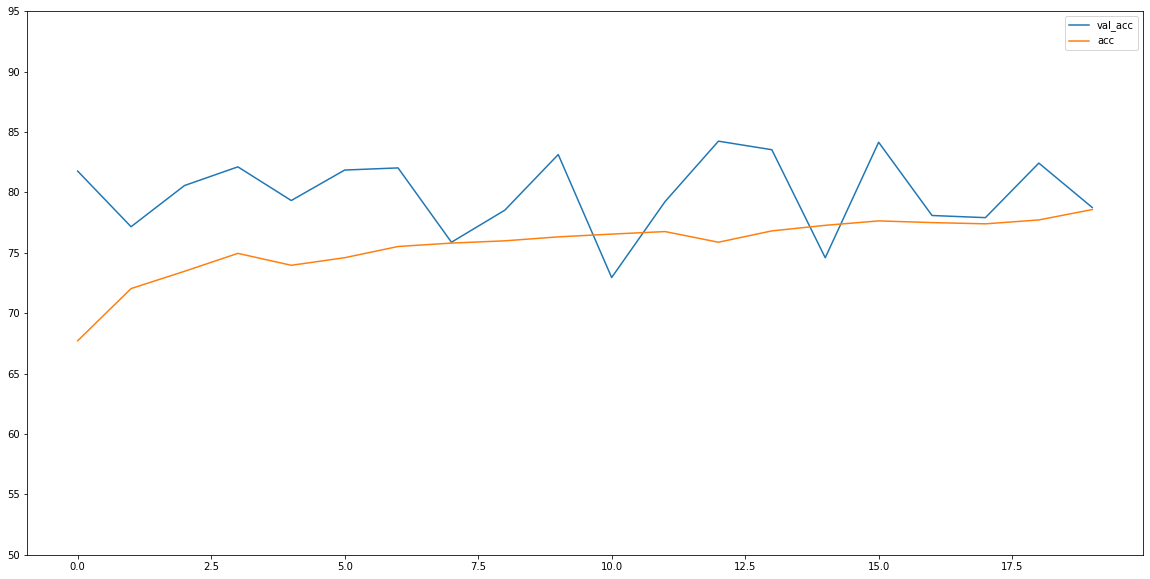

In [ ]:
plt.figure(figsize=(30,20))
val_acc=np.asarray(fmodel.history.history['val_accuracy'])*100
acc=np.asarray(fmodel.history.history['accuracy'])*100
acc=pd.DataFrame({'val_acc':val_acc,'acc':acc})
acc.plot(figsize=(20,10),yticks=range(50,100,5))

**Plotting Loss and Validation Loss**

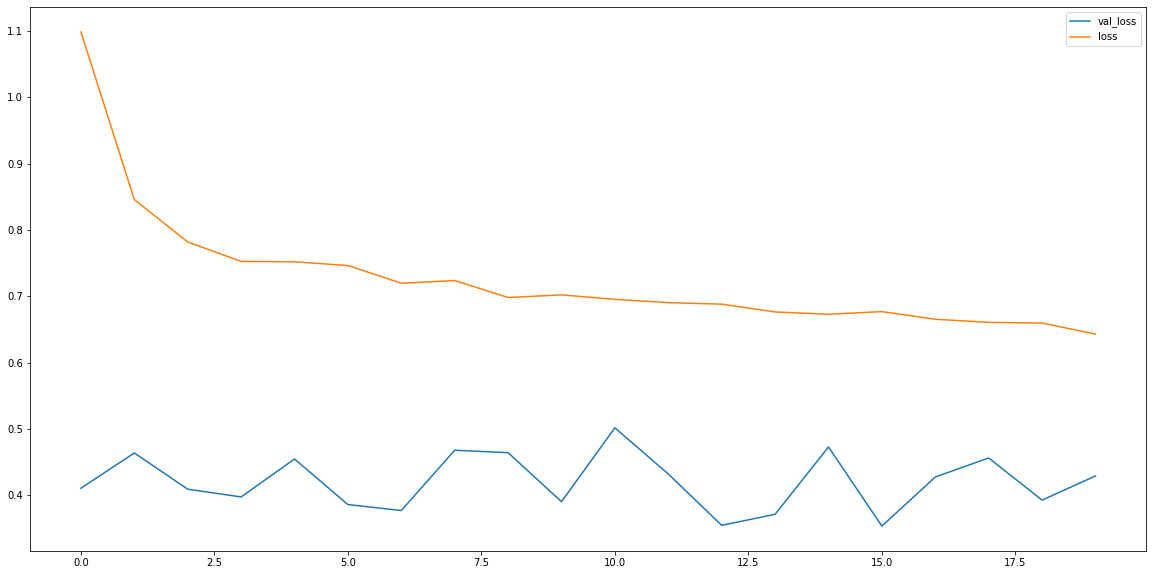

In [ ]:
loss=fmodel.history.history['loss']
val_loss=fmodel.history.history['val_loss']
loss=pd.DataFrame({'val_loss':val_loss,'loss':loss})
loss.plot(figsize=(20,10))

**Model testing**

In [ ]:
y=[]

test.reset()

for i in tqdm(range(4)):
    _,target=test.__getitem__(i)
    for j in target:
        y.append(j)

100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


In [ ]:
test.reset()
y_pred=fmodel.predict(test)

In [ ]:
pred=[]
for i in y_pred:
    if i[0]>=0.5:
        pred.append(1)
    else:
        pred.append(0)

In [ ]:
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report

In [ ]:
print(classification_report(y,pred[:len(y)]))

              precision    recall  f1-score   support

         0.0       0.97      0.78      0.87        99
         1.0       0.55      0.93      0.69        29

    accuracy                           0.81       128
   macro avg       0.76      0.85      0.78       128
weighted avg       0.88      0.81      0.83       128



**ROC Curve**

The area under the curve is: 0.9171020550330895


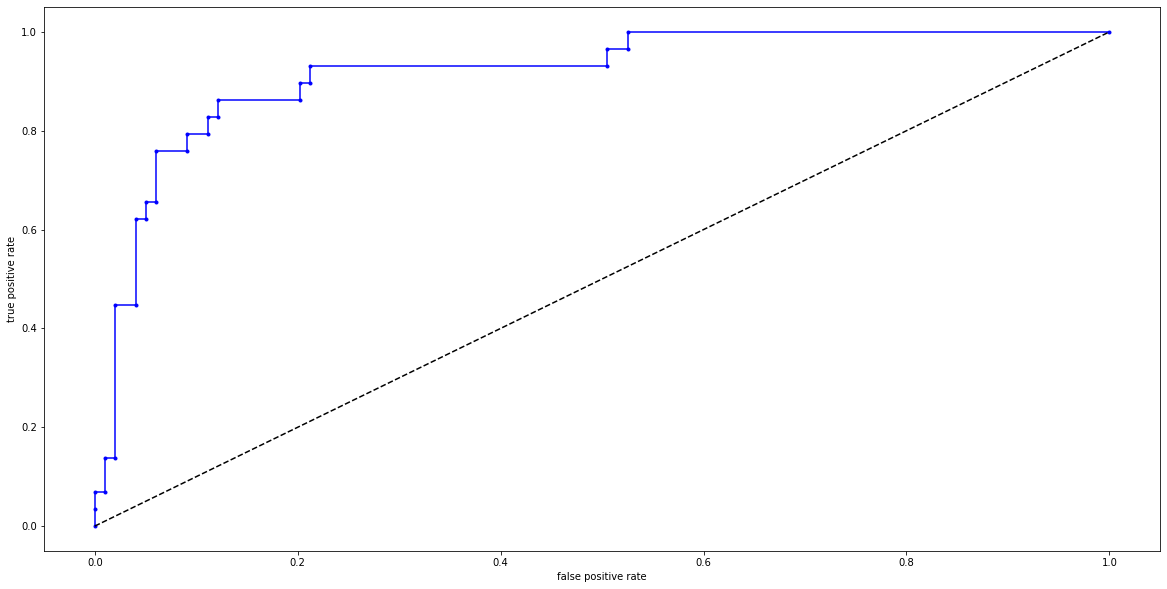

In [ ]:
plt.figure(figsize=(20,10))
fprr,tprr,_=roc_curve(y,y_pred[:len(y)])
area_under_curver=auc(fprr,tprr)
print('The area under the curve is:',area_under_curver)
# Plot area under curve
plt.plot(fprr,tprr,'b.-')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fprr,fprr,linestyle='--',color='black')

##### **1. VGG16**

In [ ]:
import keras
from tensorflow.keras import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

vgg_model = VGG16(input_shape = (256,256,3),include_top = False,weights = 'imagenet')
output = vgg_model.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg_model.input, output)

for layer in vgg_model.layers:
  layer.trainable = False

vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
____________________________________________________________

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape=(256,256,3)
vmodel = Sequential()
vmodel.add(vgg_model)
vmodel.add(Dense(512, activation='relu', input_dim=input_shape))
vmodel.add(Dropout(0.3))
vmodel.add(Dense(512, activation='relu'))
vmodel.add(Dropout(0.3))
vmodel.add(Dense(1, activation='sigmoid'))

##### **2. Compile Model**

In [ ]:
vmodel.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
vmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 32768)             14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 31,755,585
Trainable params: 17,040,897
Non-trainable params: 14,714,688
___________________________________

##### **3. Train the Model**

In [ ]:
vmodel.fit(train,epochs=20,callbacks=[reduce_lr],steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 213s 2s/step - loss: 0.7136 - accuracy: 0.7559 - val_loss: 0.3787 - val_accuracy: 0.8251
Epoch 2/20
100/100 [==============================] - 213s 2s/step - loss: 0.7257 - accuracy: 0.7479 - val_loss: 0.3766 - val_accuracy: 0.8216
Epoch 3/20
100/100 [==============================] - 212s 2s/step - loss: 0.7088 - accuracy: 0.7526 - val_loss: 0.3884 - val_accuracy: 0.8145

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 4/20
100/100 [==============================] - 211s 2s/step - loss: 0.6888 - accuracy: 0.7710 - val_loss: 0.3983 - val_accuracy: 0.8012
Epoch 5/20
100/100 [==============================] - 211s 2s/step - loss: 0.6721 - accuracy: 0.7687 - val_loss: 0.3885 - val_accuracy: 0.8070
Epoch 6/20
100/100 [==============================] - 213s 2s/step - loss: 0.6928 - accuracy: 0.7594 - val_loss: 0.3682 - val_accuracy: 0.8384

Epoch 00006: ReduceLROnPlateau reducing learning rate to 6.2

**Saving the Model**

In [ ]:
vmodel.save(f'/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data/model_vgg16.h5')

**Plotting accuracy and validation accuracy**

<Figure size 2880x2160 with 0 Axes>

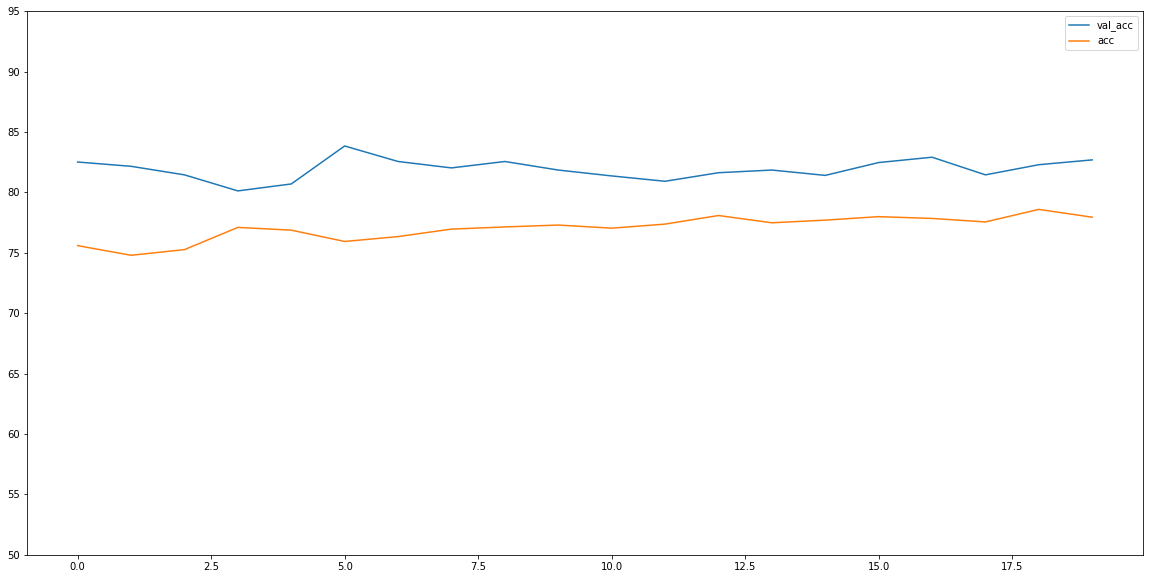

In [ ]:
plt.figure(figsize=(40,30))
vval_acc=np.asarray(vmodel.history.history['val_accuracy'])*100
vacc=np.asarray(vmodel.history.history['accuracy'])*100
vacc=pd.DataFrame({'val_acc':vval_acc,'acc':vacc})
vacc.plot(figsize=(20,10),yticks=range(50,100,5))

**Plotting Loss and Validation Loss**

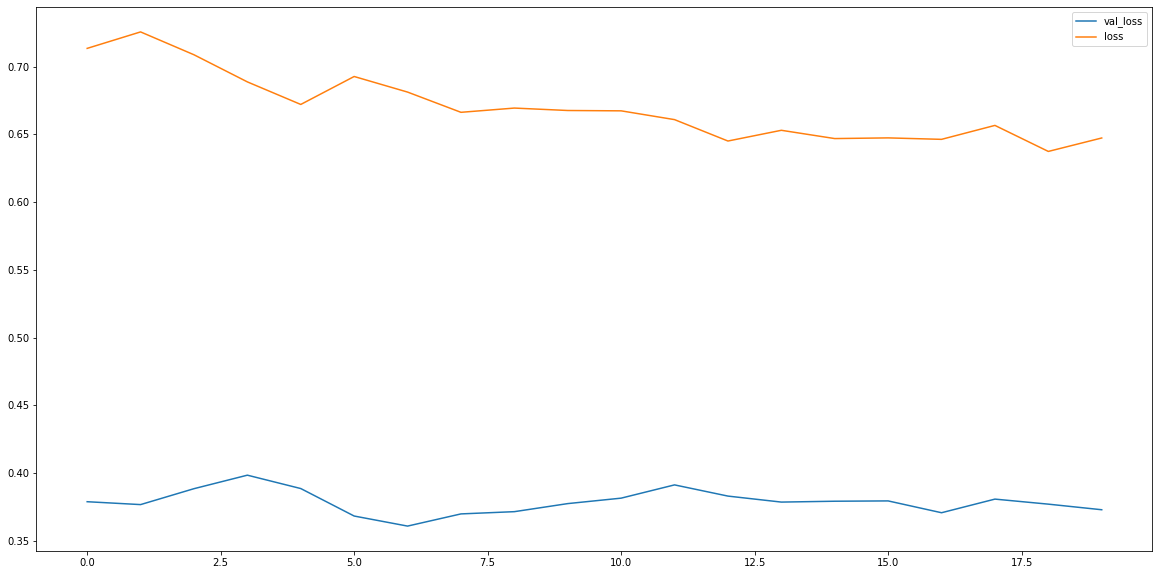

In [ ]:
vloss=vmodel.history.history['loss']
vval_loss=vmodel.history.history['val_loss']
vloss=pd.DataFrame({'val_loss':vval_loss,'loss':vloss})
vloss.plot(figsize=(20,10))

**Model Testing**

In [ ]:
y=[]

test.reset()

for i in tqdm(range(4)):
    _,target=test.__getitem__(i)
    for j in target:
        y.append(j)

100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


In [ ]:
test.reset()
y_predv=vmodel.predict(test)

In [ ]:
predv=[]
for i in y_predv:
    if i[0]>=0.5:
        predv.append(1)
    else:
        predv.append(0)

**ROC Curve**

In [ ]:
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report

print(classification_report(y,predv[:len(y)]))

              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86       102
         1.0       0.50      0.81      0.62        26

    accuracy                           0.80       128
   macro avg       0.72      0.80      0.74       128
weighted avg       0.85      0.80      0.81       128



The area under the curve is: 0.9095022624434389


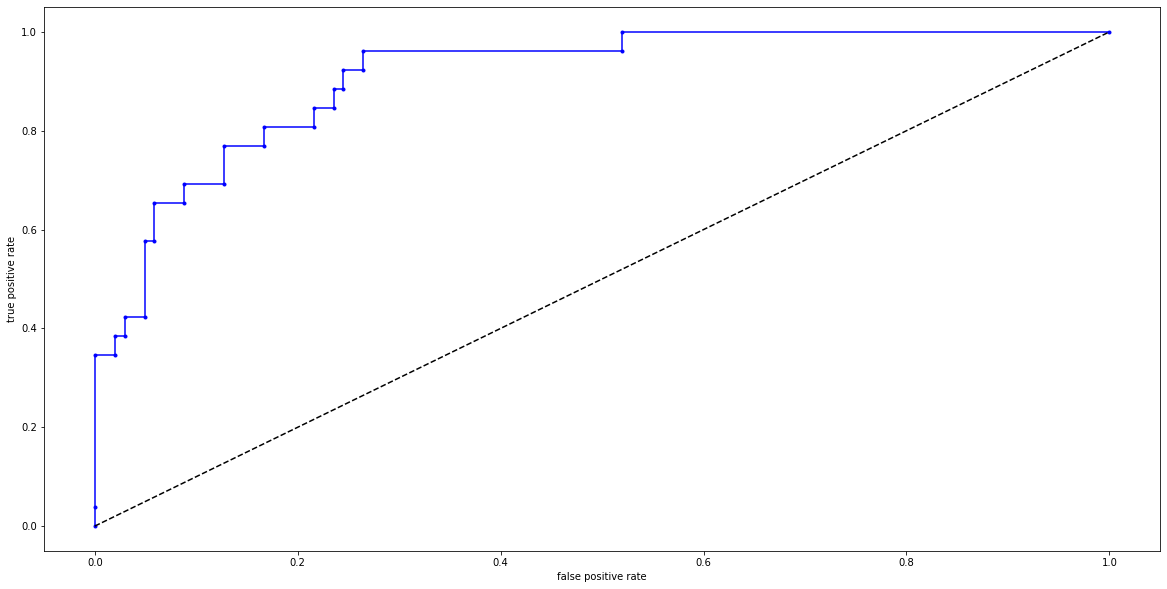

In [ ]:
plt.figure(figsize=(20,10))
fprv,tprv,_=roc_curve(y,y_predv[:len(y)])
area_under_curvev=auc(fprv,tprv)
print('The area under the curve is:',area_under_curvev)
# Plot area under curve
plt.plot(fprv,tprv,'b.-')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fprv,fprv,linestyle='--',color='black')

##### **2. ResNet50**

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
import keras

resnet_model = ResNet50(input_shape = (256,256,3), include_top = False, weights = 'imagenet')
output = resnet_model.layers[-1].output
output = keras.layers.Flatten()(output)

resnet_model = Model(resnet_model.input, output)

for layer in resnet_model.layers:
  layer.trainable = False

resnet_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________

**Model Compilation**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
input_shape=(256,256,3)
rmodel = Sequential()
rmodel.add(resnet_model)
rmodel.add(Dense(512, activation='relu', input_dim=input_shape))
rmodel.add(Dropout(0.3))
rmodel.add(Dense(512, activation='relu'))
rmodel.add(Dropout(0.3))
rmodel.add(Dense(1, activation='sigmoid'))

rmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

rmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 131072)            23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 90,960,257
Trainable params: 67,372,545
Non-trainable params: 23,587,712
_________________________________

**Model Training**

In [ ]:
rmodel.fit(train,epochs=20,callbacks=[reduce_lr],steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 212s 2s/step - loss: 2.7992 - accuracy: 0.6161 - val_loss: 0.6358 - val_accuracy: 0.6109
Epoch 2/20
100/100 [==============================] - 211s 2s/step - loss: 0.9396 - accuracy: 0.6650 - val_loss: 0.5876 - val_accuracy: 0.7313
Epoch 3/20
100/100 [==============================] - 211s 2s/step - loss: 0.9658 - accuracy: 0.7266 - val_loss: 0.5312 - val_accuracy: 0.7269
Epoch 4/20
100/100 [==============================] - 211s 2s/step - loss: 0.9552 - accuracy: 0.7334 - val_loss: 0.5155 - val_accuracy: 0.8132
Epoch 5/20
100/100 [==============================] - 212s 2s/step - loss: 0.9398 - accuracy: 0.5574 - val_loss: 0.5860 - val_accuracy: 0.7734
Epoch 6/20
100/100 [==============================] - 211s 2s/step - loss: 0.9216 - accuracy: 0.7421 - val_loss: 0.5566 - val_accuracy: 0.7649
Epoch 7/20
100/100 [==============================] - 213s 2s/step - loss: 0.9330 - accuracy: 0.7525 - val_loss: 0.5804 - val_accuracy: 0.7508

**Saving the Model**

In [ ]:
rmodel.save(f'/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data/model_resnet50.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


**Plotting & Validation Accuracy**

<Figure size 2160x1440 with 0 Axes>

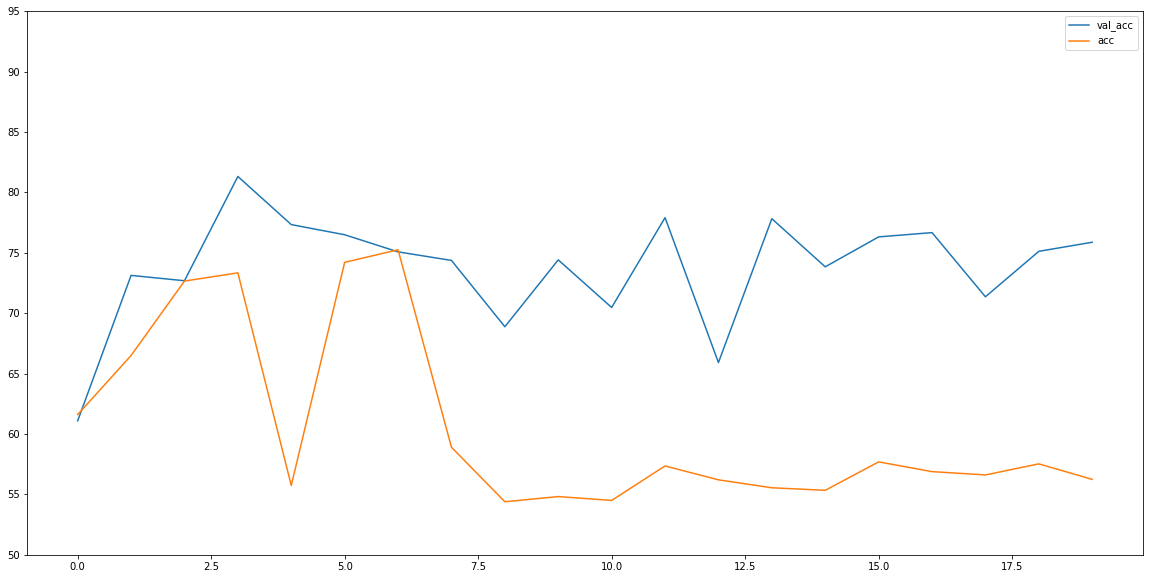

In [ ]:
plt.figure(figsize=(30,20))
rval_acc=np.asarray(rmodel.history.history['val_accuracy'])*100
racc=np.asarray(rmodel.history.history['accuracy'])*100
racc=pd.DataFrame({'val_acc':rval_acc,'acc':racc})
racc.plot(figsize=(20,10),yticks=range(50,100,5))

**Plotting & Validation Loss**

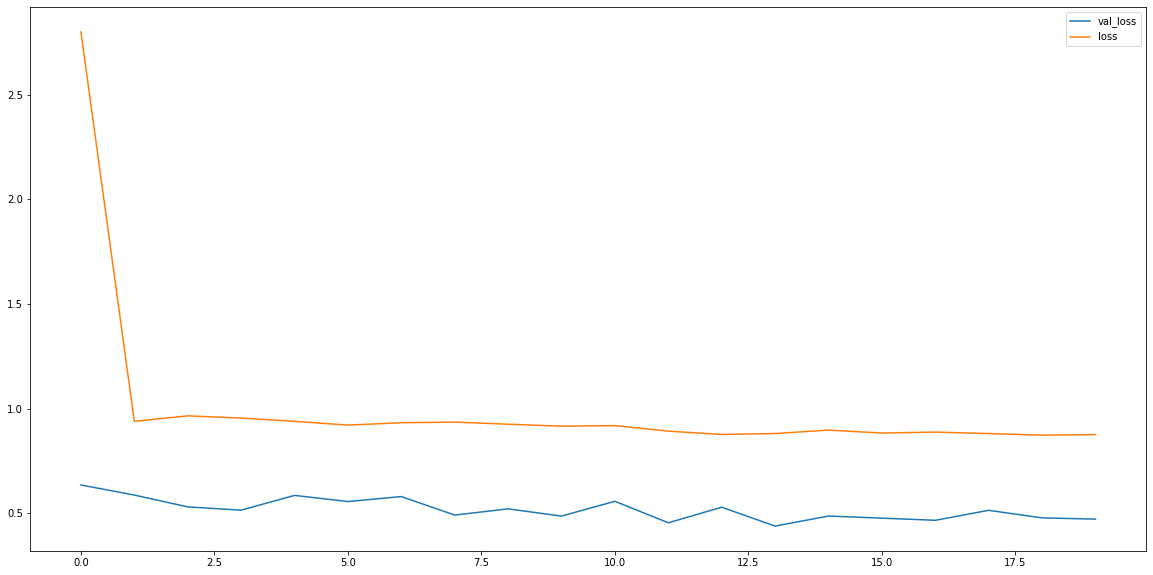

In [ ]:
rloss=rmodel.history.history['loss']
rval_loss=rmodel.history.history['val_loss']
rloss=pd.DataFrame({'val_loss':rval_loss,'loss':rloss})
rloss.plot(figsize=(20,10))

**Model Testing**

In [ ]:
y=[]

test.reset()

for i in tqdm(range(4)):
    _,target=test.__getitem__(i)
    for j in target:
        y.append(j)

100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


In [ ]:
test.reset()
y_predr=rmodel.predict(test)

predr=[]
for i in y_predr:
    if i[0]>=0.5:
        predr.append(1)
    else:
        predr.append(0)

**Classification Report and ROC Curve**

In [ ]:
print(classification_report(y,predr[:len(y)]))

              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82        93
         1.0       0.55      0.80      0.65        35

    accuracy                           0.77       128
   macro avg       0.73      0.78      0.74       128
weighted avg       0.81      0.77      0.78       128



The area under the curve is: 0.8328725038402458


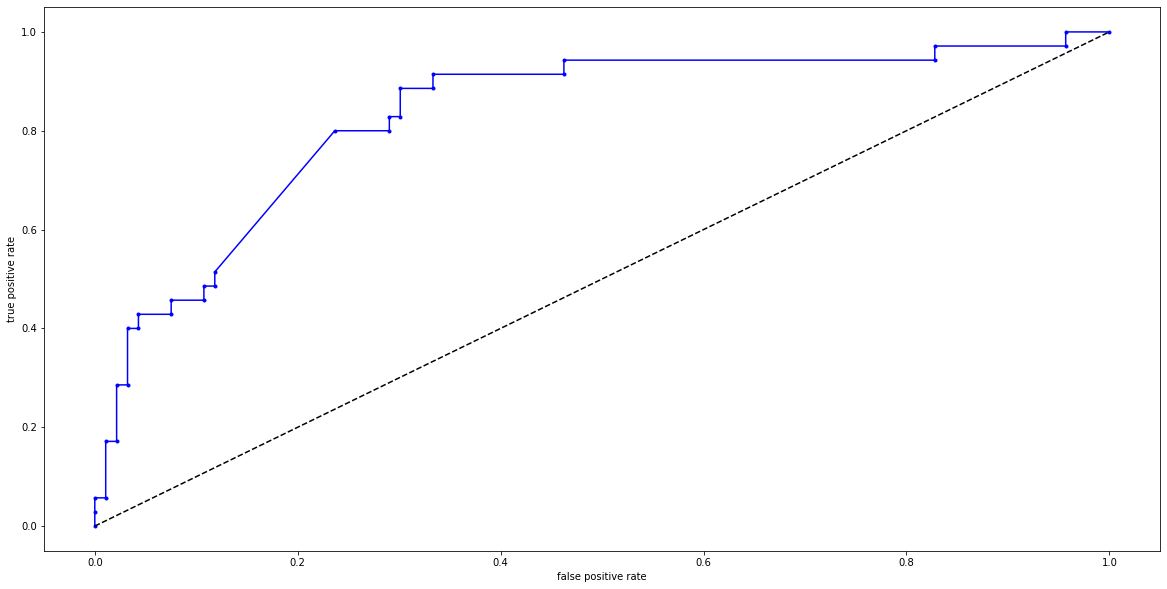

In [ ]:
plt.figure(figsize=(20,10))
fprr,tprr,_=roc_curve(y,y_predr[:len(y)])
area_under_curver=auc(fprr,tprr)
print('The area under the curve is:',area_under_curver)
# Plot area under curve
plt.plot(fprr,tprr,'b.-')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fprr,fprr,linestyle='--',color='black')

##### **3. InceptionNet v3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inc_model = InceptionV3(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
output = inc_model.layers[-1].output
output = keras.layers.Flatten()(output)

inc_model = Model(inc_model.input, output)

In [ ]:
for layer in inc_model.layers:
  layer.trainable = False

In [ ]:
inc_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

**Model Compilation**

In [ ]:
input_shape=(256,256,3)
in_model = Sequential()
in_model.add(inc_model)
in_model.add(Dense(512, activation='relu', input_dim=input_shape))
in_model.add(Dropout(0.3))
in_model.add(Dense(512, activation='relu'))
in_model.add(Dropout(0.3))
in_model.add(Dense(1, activation='sigmoid'))

in_model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
in_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 73728)             21802784  
_________________________________________________________________
dense_9 (Dense)              (None, 512)               37749248  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 59,815,201
Trainable params: 38,012,417
Non-trainable params: 21,802,784
_________________________________

**Model Training**

In [ ]:
in_model.fit(train,epochs=20,callbacks=[reduce_lr],steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/20
100/100 [==============================] - 212s 2s/step - loss: 3.0983 - accuracy: 0.6504 - val_loss: 0.5596 - val_accuracy: 0.6923
Epoch 2/20
100/100 [==============================] - 208s 2s/step - loss: 0.9149 - accuracy: 0.7378 - val_loss: 0.4895 - val_accuracy: 0.7981
Epoch 3/20
100/100 [==============================] - 208s 2s/step - loss: 0.8879 - accuracy: 0.7541 - val_loss: 0.4682 - val_accuracy: 0.7986
Epoch 4/20
100/100 [==============================] - 208s 2s/step - loss: 0.9085 - accuracy: 0.6005 - val_loss: 0.5515 - val_accuracy: 0.7685
Epoch 5/20
100/100 [==============================] - 207s 2s/step - loss: 0.8976 - accuracy: 0.6099 - val_loss: 0.4377 - val_accuracy: 0.7596

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
100/100 [==============================] - 207s 2s/step - loss: 0.8525 - accuracy: 0.6179 - val_loss: 0.4337 - val_accuracy: 0.7490
Epoch 7/20
100/100 [==============================] - 207s 2s

**Saving the Model**

In [ ]:
in_model.save(f'/content/drive/MyDrive/AI_ML_Projects/Capstone Project/working_data/model_inceptionnet.h5')

**Plotting & Validation Accuracy**

<Figure size 2160x1440 with 0 Axes>

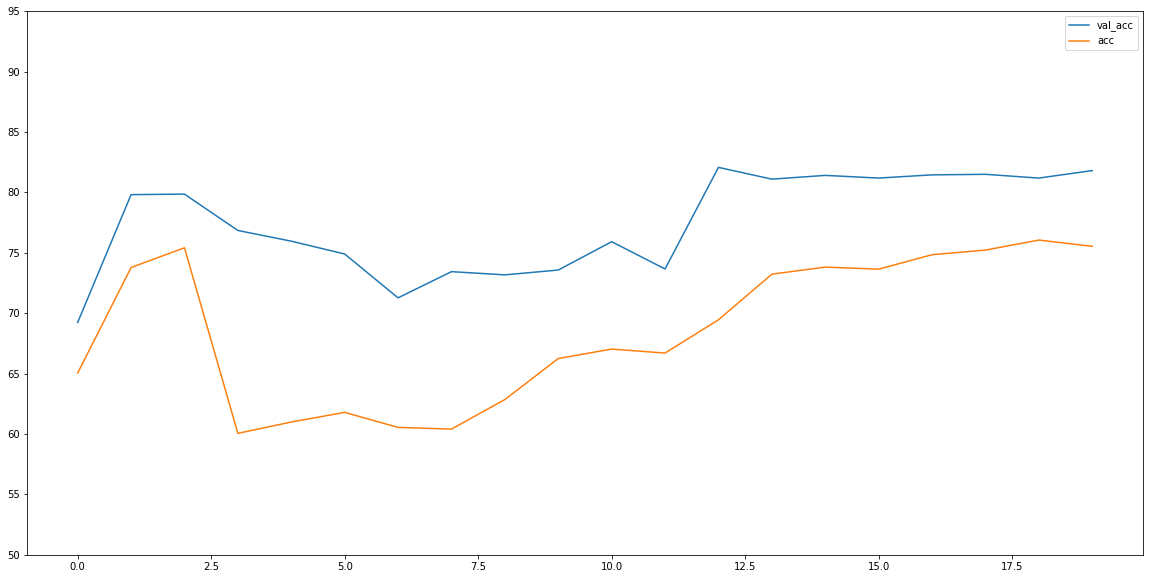

In [ ]:
plt.figure(figsize=(30,20))
ival_acc=np.asarray(in_model.history.history['val_accuracy'])*100
iacc=np.asarray(in_model.history.history['accuracy'])*100
iacc=pd.DataFrame({'val_acc':ival_acc,'acc':iacc})
iacc.plot(figsize=(20,10),yticks=range(50,100,5))

**Plotting & Validation Loss**

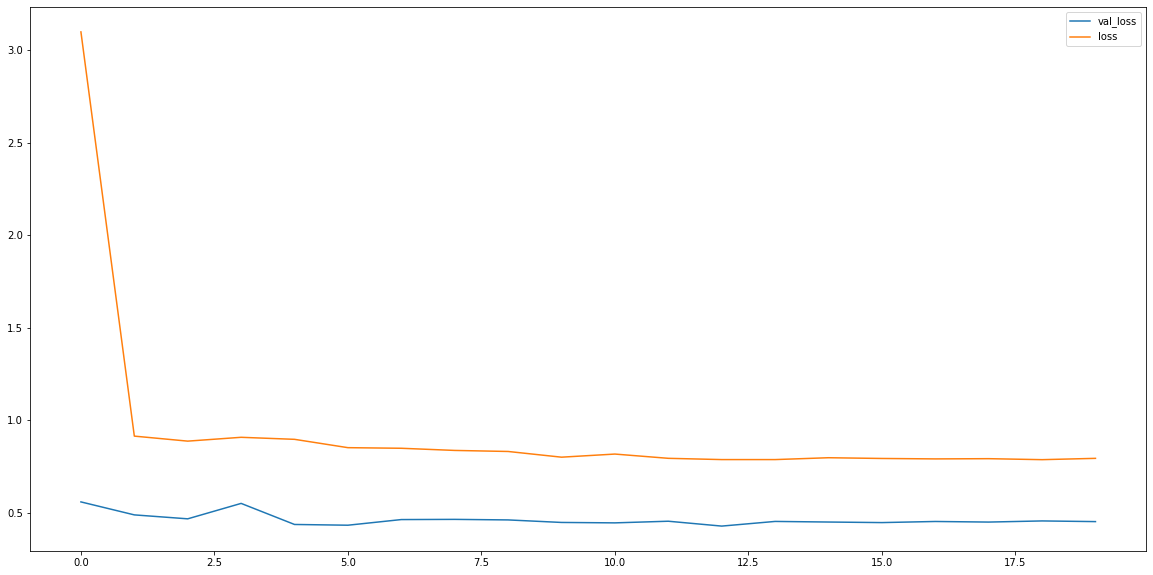

In [ ]:
in_loss=in_model.history.history['loss']
in_val_loss=in_model.history.history['val_loss']
in_loss=pd.DataFrame({'val_loss':in_val_loss,'loss':in_loss})
in_loss.plot(figsize=(20,10))

**Model testing**

In [ ]:
y=[]

test.reset()

for i in tqdm(range(4)):
    _,target=test.__getitem__(i)
    for j in target:
        y.append(j)

100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


In [ ]:
test.reset()
y_predi=in_model.predict(test)

predi=[]
for i in y_predi:
    if i[0]>=0.5:
        predi.append(1)
    else:
        predi.append(0)

**Classification report & ROC Curve**

In [ ]:
print(classification_report(y,predi[:len(y)]))

              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91       107
         1.0       0.55      0.81      0.65        21

    accuracy                           0.86       128
   macro avg       0.75      0.84      0.78       128
weighted avg       0.89      0.86      0.87       128



The area under the curve is: 0.8680462839341344


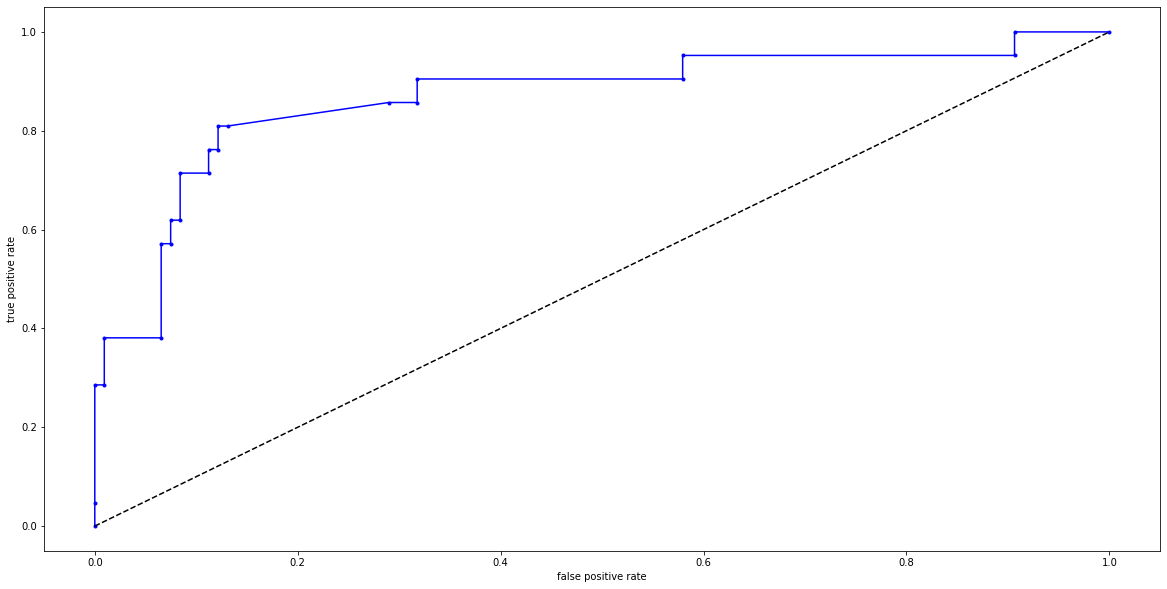

In [ ]:
plt.figure(figsize=(20,10))
fpri,tpri,_=roc_curve(y,y_predi[:len(y)])
area_under_curvei=auc(fpri,tpri)
print('The area under the curve is:',area_under_curvei)
# Plot area under curve
plt.plot(fpri,tpri,'b.-')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpri,fpri,linestyle='--',color='black')